**Universidade Federal de Catalão (UFCAT)**  
**Pesquisa de Iniciação Científica (IC) - ciclo 2021 a 2022**  


---
Autores:  
1. Lucas Cruvinel (***UFCAT***)  
2. Wanderlei Malaquias Pereira Junior (***UFCAT***)  
3. Amanda Campos (***UFRJ***)  
4. Antover P. Sarmento (***UFCAT***)  
5. Daniel Lima Araújo (***UFG***)  
6. Rogério Espindola (***UFRJ***)  
7. Gustavo de Assis Costa (***IFG***)
---
Este *pipeline* gera uma IA treinada para o problema de predição da resistência mecânica à compressão de corpos de prova de concreto simples.

Breve descrição das variáveis:

Atributo           | Unidade   | Nome na coleção               | Sigla
---------          | --------- | ---------                     | -------
Cimento            | kg/m³     | Cement                        | $c$  
Escória Alto Forno | kg/m³     | blast_furnace_slag            | $bfs$
Cinza Volante      | kg/m³     | fly_ash                       | $fa$
Água               | kg/m³     | water                         | $w$
Superplastificante | kg/m³     | superplasticizer              | $sp$
Agregado Graúdo    | kg/m³     | coarse_aggregate              | $cag$
Agregado Fino      | kg/m³     | fine_aggregate                | $fag$
Idade              | dias      | age                           | $t$  
f_ck               | MPa       | concrete_compressive_strength | $f_{ck}$


# Etapa de instalação e importações das fontes externas


Instalação de bibliotecas não existentes:
- ```xlsxwriter```;
- ```openpyxl```;
- ```emoji```;

_Em caso de necessidade de repetidas execuções não é necessário instalar novamente._

Carregando bibliotecas existentes:
- ```IA```;
- ```numpy```;
- ```pandas```;
- ```seaborn```;
- ```sklearn```.

Lista de emojis
https://unicode.org/emoji/charts/emoji-list.html

In [ ]:
!pip install XlsxWriter
!pip install openpyxl
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.6/356.6 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.6.0-py2.py3-none-any.whl size=351311 sha256=b77d347aee8d0af32e3c6e50f565e86e00bc3dfad98a34f5d994adcd59fc68be
  Stored in directory: /root/.cache/pip/wheels/ea/0b/64/114bc939d0083621aa41521e21be246c888260b8aa21e6c1ad
Successfully built emoji


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xlsxwriter as xw
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from random import randint
import statistics
from math import sqrt
import emoji

In [2]:
# Importação fonte externa
#from IA_COMMON_LIBRARY import *

## **1.1 Carregando o banco de dados do problema**

O banco de dados original foi construído em uma planilha eletrônica de Excel. A planilha agrupo todos os bancos encontrados nesta pesquisa.

In [4]:
# Leitura do dataset
DF_CONCRETO = pd.read_excel('dataset-full.xlsx')

# Mudança de alguns nomes de colunas
DF_CONCRETO.rename(columns = {  'Cement':'c',
                                'Water':'w',
                                'BFS':'bd',
                                'FlyAsh': 'fa',
                                'SP': 'sp',
                                'CA': 'cag',
                                'FA': 'fag',
                                'D': 't',
                                'Strength': 'f_ck'
                              }, inplace = True)
DF_CONCRETO.head()

,c,bd,fa,w,sp,cag,fag,t,f_ck,Ref
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111,Yeh
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366,Yeh
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535,Yeh
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780,Yeh
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075,Yeh


## **1.2 Tratamento dos dados**

### 1.2.1 Limpeza dos dados

Devido as características deste _dataset_ foi criada uma taxa água-cimento ($a/c$), depois eliminou-se a quantidade de água. As adições de filler tbm foram agrupas em uma coluna.

In [5]:
# Limpeza sim ou não
TRATAMENTO = True

# Execução da limpeza
DF_TRATADO = DF_CONCRETO.copy()

# Execução da limpeza
DF_TRATADO = DF_TRATADO.drop(columns = 'Ref')
DF_TRATADO = DF_TRATADO.drop_duplicates()
if TRATAMENTO:
    # Eliminar registros com idade maior que 28 dias (atributo 'age')
    # DF_TRATADO = DF_TRATADO.drop(DF_TRATADO[DF_TRATADO.t > 28].index)

    # Criação da coluna relação água cimento (a per c) e eliminação do atributo água ('water')
    DF_TRATADO['w-c ratio'] = DF_TRATADO['w'] / DF_TRATADO['c']
    DF_TRATADO = DF_TRATADO.drop(columns = ['w'])

    # Juntar colunas dos atributos 'Blast Furnace' e 'Fly Ash' e criar o atributo adição ('add')
    DF_TRATADO['add'] = DF_TRATADO['bd'] + DF_TRATADO['fa']
    DF_TRATADO = DF_TRATADO.drop(columns = ['bd', 'fa'])

    # Eliminar suplesplasticizer (sp)
    # DF_TRATADO = DF_TRATADO.drop(columns = 'sp')

In [6]:
DF_TRATADO.head()

,c,sp,cag,fag,t,f_ck,w-c ratio,add
0,540.0,2.5,1040.0,676.0,28,79.986111,0.300000,0.0
1,540.0,2.5,1055.0,676.0,28,61.887366,0.300000,0.0
2,332.5,0.0,932.0,594.0,270,40.269535,0.685714,142.5
3,332.5,0.0,932.0,594.0,365,41.052780,0.685714,142.5
4,198.6,0.0,978.4,825.5,360,44.296075,0.966767,132.4


## **1.3 Descrição do banco de dados**

### 1.3.1 Descrição estatística das variáveis

In [7]:
DF_TRATADO.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
c,2358.0,285.707651,115.037061,38.000000,194.680000,275.000000,375.000000,643.000000
sp,2358.0,3.751092,5.057820,0.000000,0.000000,0.600000,6.860000,32.200000
cag,2358.0,1000.156637,121.301509,723.000000,932.000000,1005.600000,1088.550000,1419.300000
fag,2358.0,724.237171,122.820840,175.950000,645.000000,742.000000,798.900000,1066.000000
t,2358.0,62.591179,86.443705,1.000000,7.000000,28.000000,90.000000,365.000000
f_ck,2358.0,40.063573,20.140161,1.760000,24.900968,38.947692,52.737500,113.100000
w-c ratio,2358.0,0.789480,0.439137,0.266893,0.500000,0.703588,0.959648,4.868421
add,2358.0,128.675237,102.747098,0.000000,0.000000,122.580000,200.000000,594.000000


### 1.3.2 Plotagem do histograma das variáveis

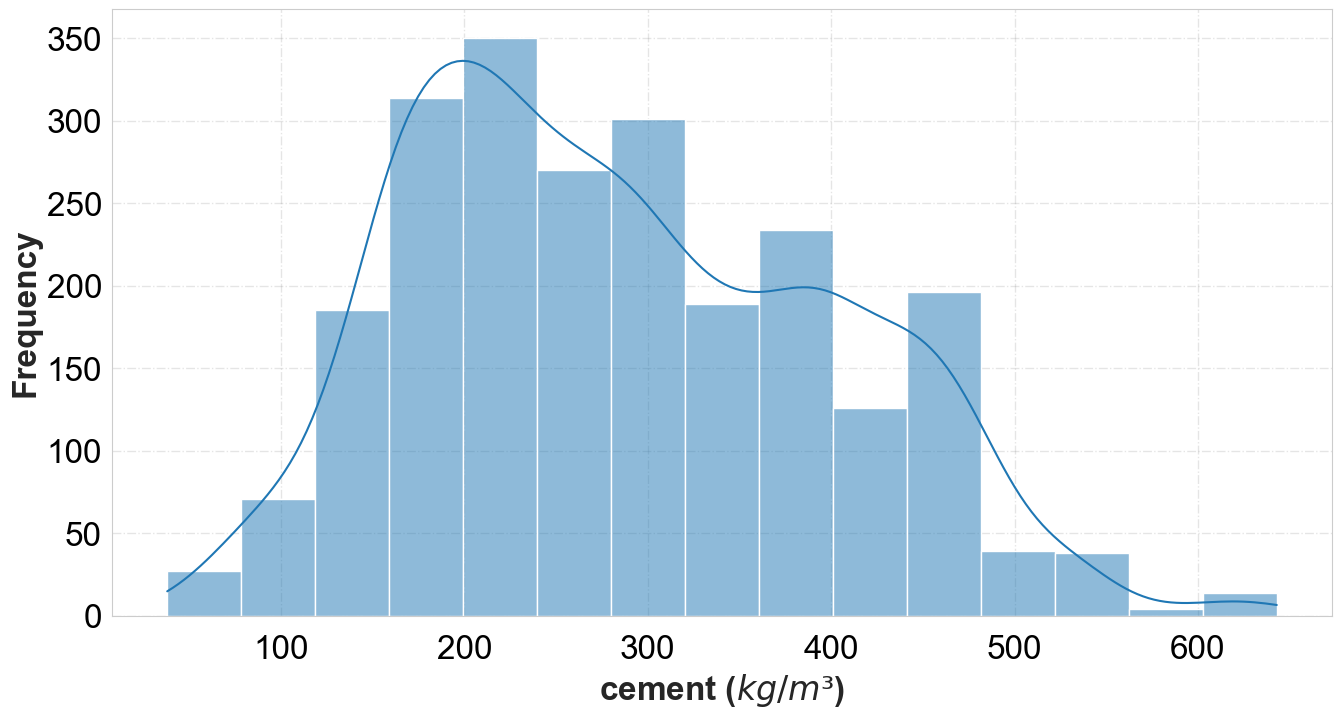

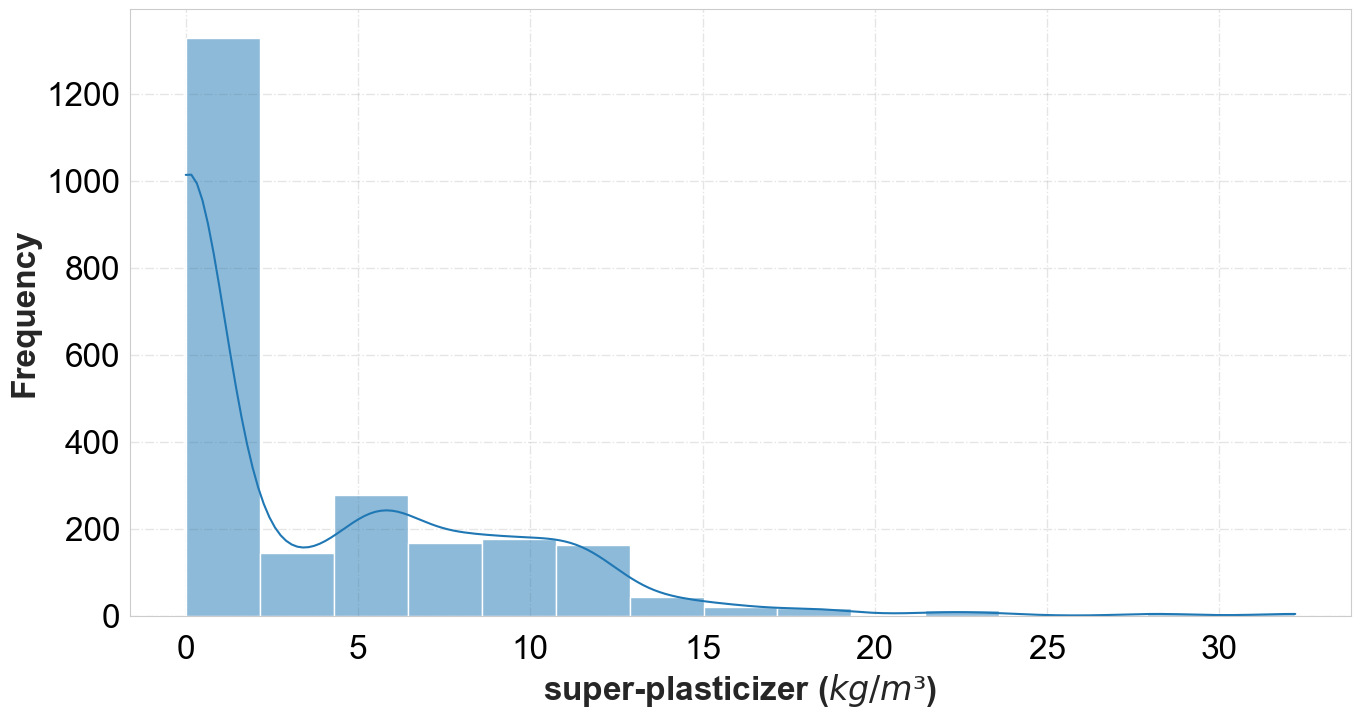

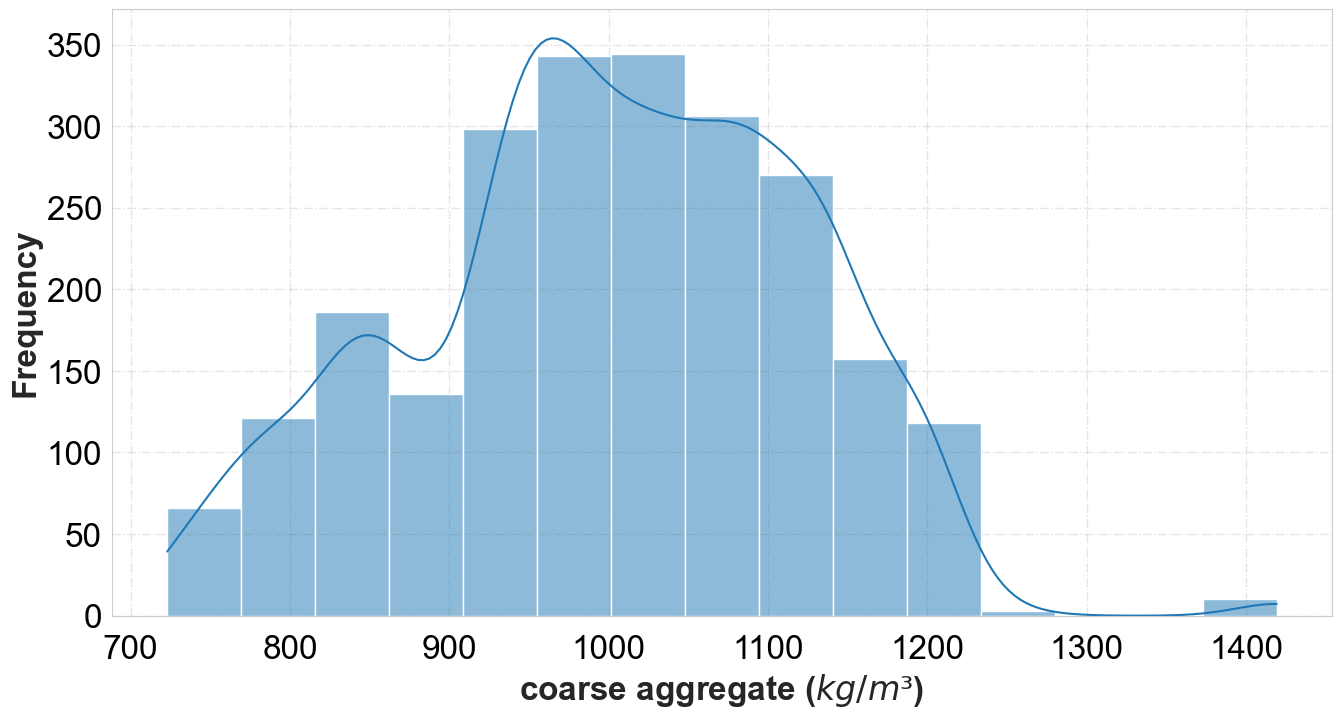

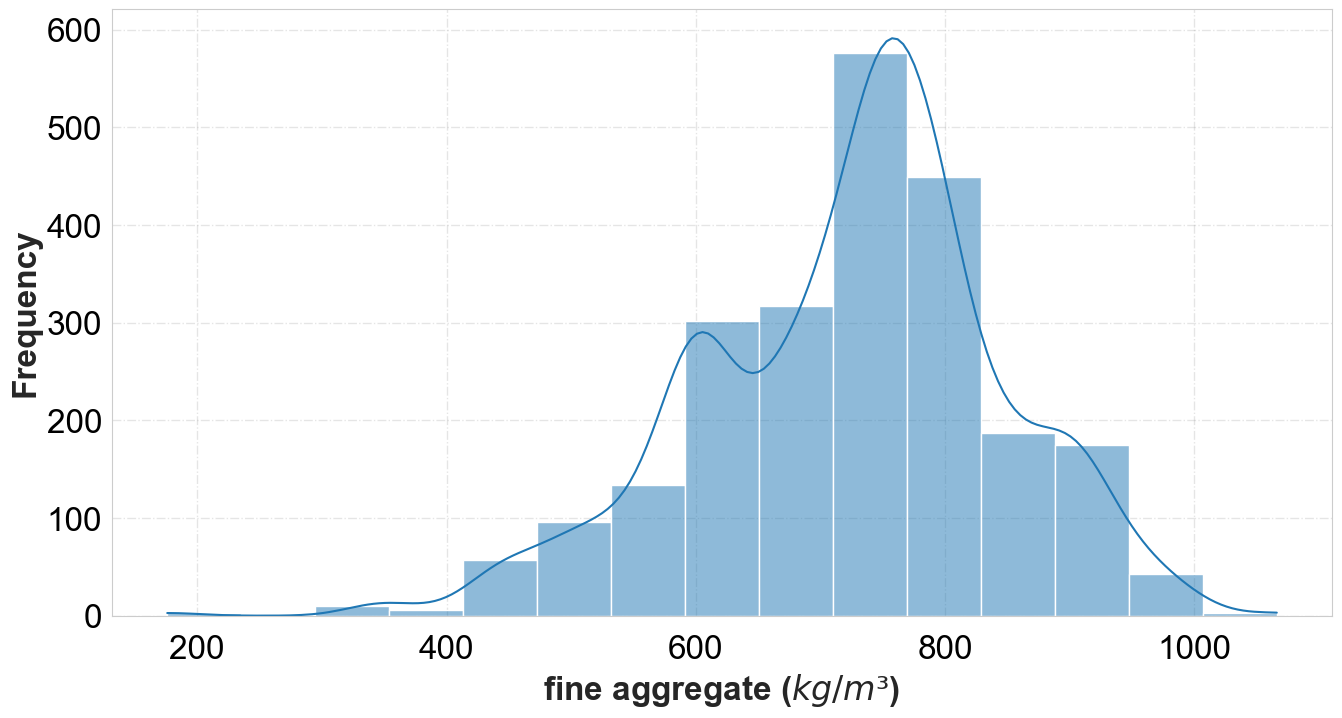

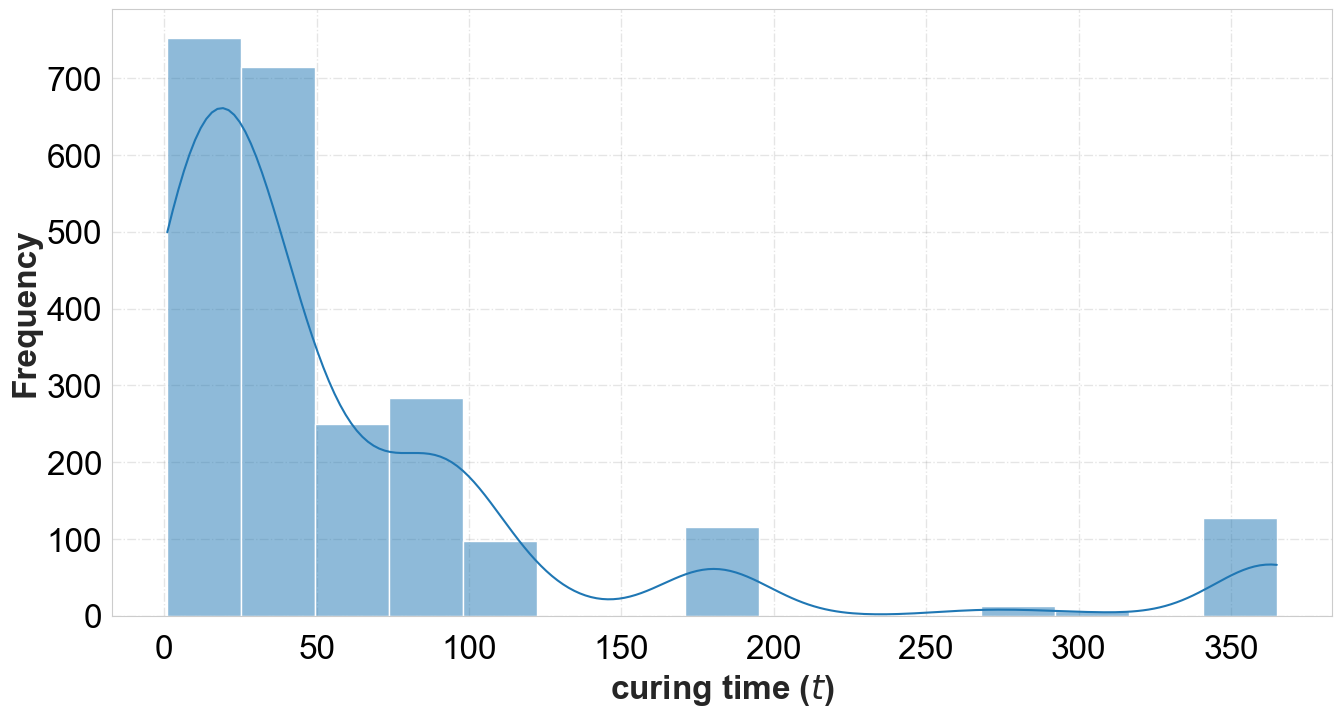

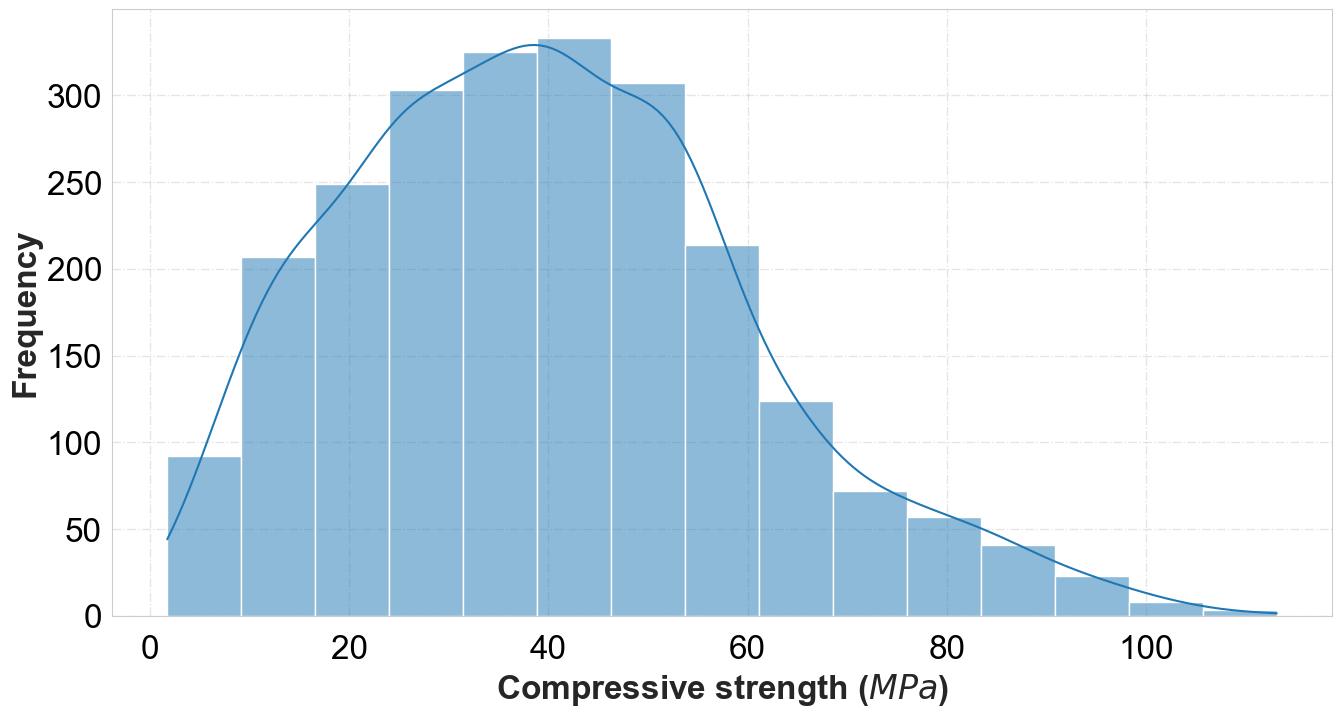

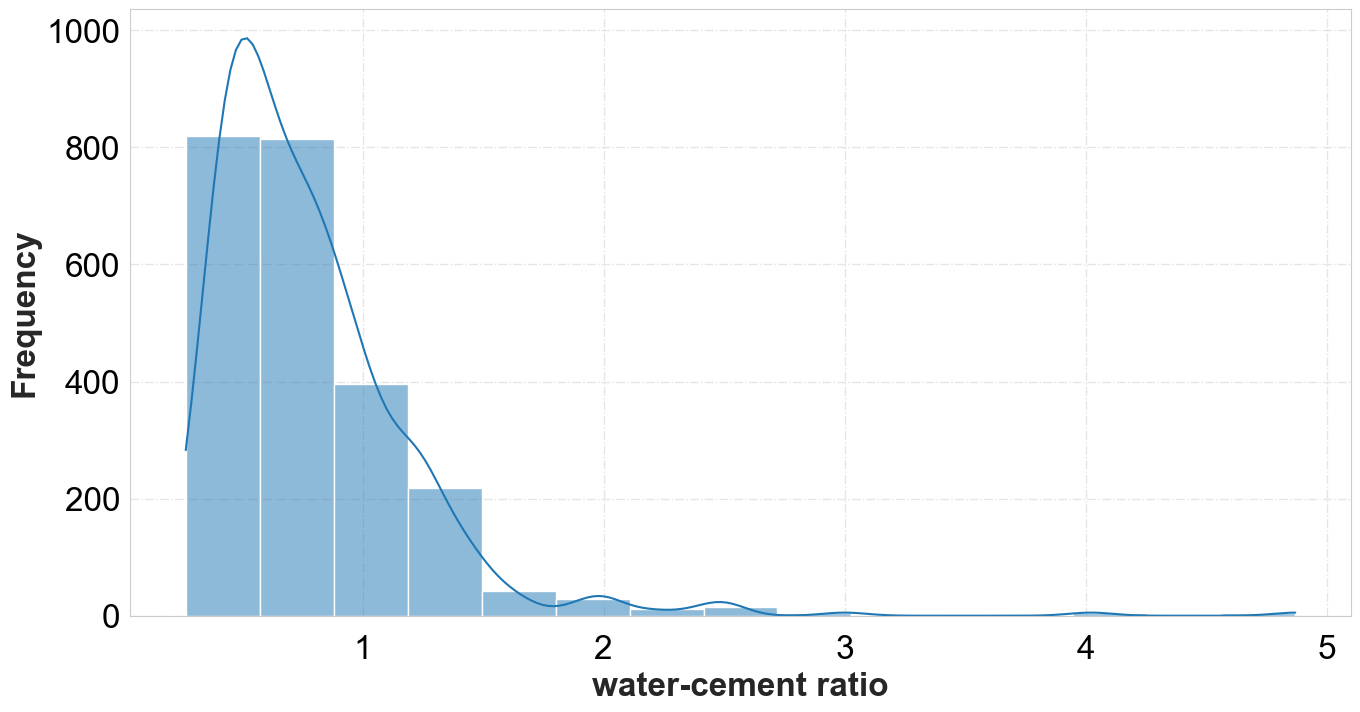

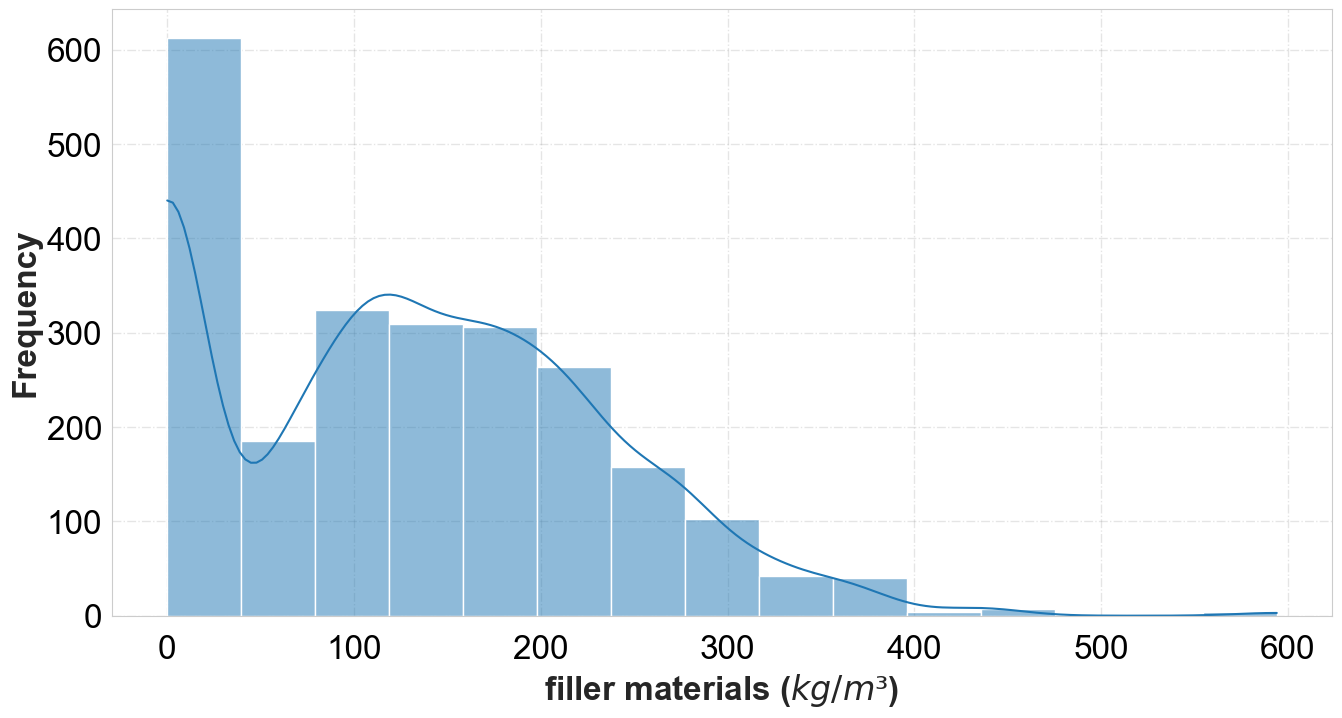

In [12]:
%run Histplot_final.ipynb
LISTA = ['cement ($kg/m³$)',
         'super-plasticizer ($kg/m³$)',
         'coarse aggregate ($kg/m³$)',
         'fine aggregate ($kg/m³$)',
         'curing time ($t$)',
         'Compressive strength ($MPa$)',
         'water-cement ratio',
         'filler materials ($kg/m³$)'
        ]

ID = 0

for COLUMN in DF_TRATADO:
    PLOT_SETUP = {
              'NAME': f'{COLUMN}_hisp',
              'WIDTH': 0.40, 
              'HEIGHT': 0.20,
              'DPI': 600, 
              'EXTENSION': 'jpg',
              'MARKER': 'o',
              'MARKER SIZE': 1.5,
              'Y AXIS LABEL': 'Frequency',
              'X AXIS LABEL': LISTA[ID],
              'LABELS SIZE': 24,
              'LABELS COLOR': '#000000',
              'X AXIS SIZE': 24,
              'Y AXIS SIZE': 24,
              'AXISES COLOR': '#000000',
              'ON GRID?': True,
              'LOC LEGEND': 'upper right',
              'SIZE LEGEND': 14,
              'Y LOG': False,
              'X LOG': False,
              'SMOOTH LINE': True
             }

    DATA = {
            'X': DF_TRATADO[COLUMN]
           }
    HISPLOT(DATA, PLOT_SETUP)
    ID += 1

### 1.3.3 Correlação entre as variáveis

In [13]:
CORRELACAO = DF_TRATADO.corr()
COR = CORRELACAO.unstack().sort_values(kind = 'quicksort', ascending = False)
print(COR[COR != 1].head(20))
print(COR[COR != 1].tail(20))

add        w-c ratio    0.627349
w-c ratio  add          0.627349
f_ck       t            0.461259
t          f_ck         0.461259
c          f_ck         0.458933
f_ck       c            0.458933
sp         fag          0.277565
fag        sp           0.277565
sp         f_ck         0.244059
f_ck       sp           0.244059
add        sp           0.158224
sp         add          0.158224
f_ck       cag          0.141024
cag        f_ck         0.141024
fag        w-c ratio    0.096437
w-c ratio  fag          0.096437
c          t            0.050140
t          c            0.050140
cag        t            0.036953
t          cag          0.036953
dtype: float64
sp         cag         -0.112760
cag        sp          -0.112760
fag        t           -0.129668
t          fag         -0.129668
w-c ratio  sp          -0.161604
sp         w-c ratio   -0.161604
add        cag         -0.182140
cag        add         -0.182140
f_ck       fag         -0.273507
fag        f_ck        -0.27

In [ ]:
# Plotagem
CONFIG = {'NAME': 'CCS Heatmap',
          'WIDTH': 0.30,
          'HEIGHT': 0.15,
          'X AXIS LABEL': ['c', 'sp', 'cag', 'fag', 't', '$f_{ck}$', '$w / c$', 'add'],
          'Y AXIS LABEL': ['c', 'sp', 'cag', 'fag', 't', '$f_{ck}$', '$w / c$', 'add'],
          'X LABEL ROTATION': 0,
          'Y LABEL ROTATION': 0,
          'LABELS SIZE': 18,
          'LABELS COLOR': '#000000',
          'LINE_WIDTH': 12.00,
          'LINE_COLOR': '#FFFFFF',
          'CENTER COLORMAP': False,
          'ANNOT': False,
          'ANNOT SIZE': 12,
          'ANNOT COLOR': '#FFFFFF',
          'COLORBAR': True,
          'COLORBAR_FONT_SIZE': 15,
          'COLORBAR_OR': 'vertical',
          'COLOR_MAP': 'RdBu',
          'EXTENSION': 'svg',
          'DPI': 600,
         }

DADOS = {'CORR': CORRELACAO}
CORRELATION_CHART(DADOS, CONFIG)

## **1.4 Padronização dos dados**

Aqui foi empregada a padronização dos dados do tipo **z-score**.

### 1.4.1 Aplicando a escala Z-score

In [14]:
ESCALAS = DF_TRATADO.describe().loc[['mean','std']]
DF_NORMAL = DF_TRATADO.copy()
for COL in DF_NORMAL:
    if COL != 'f_ck':
        DF_NORMAL[COL] = DF_NORMAL[COL].apply(lambda x: (x - ESCALAS[COL][0]) / ESCALAS[COL][1])
DF_NORMAL

,c,sp,cag,fag,t,f_ck,w-c ratio,add
0,2.210525,-0.247358,0.328466,-0.392744,-0.400158,79.986111,-1.114640,-1.252349
1,2.210525,-0.247358,0.452124,-0.392744,-0.400158,61.887366,-1.114640,-1.252349
2,0.406759,-0.741642,-0.561878,-1.060383,2.399351,40.269535,-0.236294,0.134551
3,0.406759,-0.741642,-0.561878,-1.060383,3.498332,41.052780,-0.236294,0.134551
4,-0.757214,-0.741642,-0.179360,0.824476,3.440491,44.296075,0.403719,0.036252
...,...,...,...,...,...,...,...,...
2383,1.634016,-0.741642,3.455385,-3.112885,-0.400158,50.810000,-0.932464,-1.252349
2384,1.222235,-0.741642,3.455385,-3.112885,-0.400158,38.220000,-0.836312,-0.791314
2385,0.810455,-0.741642,3.455385,-3.112885,-0.400158,27.700000,-0.716119,-0.330279
2386,0.398761,-0.741642,3.455385,-3.112885,-0.400158,22.520000,-0.561622,0.130658


### 1.4.2 Escala de conversão do _dataset_ original

In [15]:
ESCALAS

,c,sp,cag,fag,t,f_ck,w-c ratio,add
mean,285.707651,3.751092,1000.156637,724.237171,62.591179,40.063573,0.789480,128.675237
std,115.037061,5.057820,121.301509,122.820840,86.443705,20.140161,0.439137,102.747098


##  **1.5 Separando os dados em entrada e saída**

Apresentando o conjunto de dados **$x_i$** e **$y(x_i)$**

In [16]:
COLUNA_Y = 'f_ck'

In [17]:
X = DF_NORMAL.drop(columns = COLUNA_Y)
Y = pd.DataFrame(DF_NORMAL[COLUNA_Y], columns = [COLUNA_Y])

### 1.5.1 Variáveis independentes ($x$)

In [18]:
X.head()

,c,sp,cag,fag,t,w-c ratio,add
0,2.210525,-0.247358,0.328466,-0.392744,-0.400158,-1.114640,-1.252349
1,2.210525,-0.247358,0.452124,-0.392744,-0.400158,-1.114640,-1.252349
2,0.406759,-0.741642,-0.561878,-1.060383,2.399351,-0.236294,0.134551
3,0.406759,-0.741642,-0.561878,-1.060383,3.498332,-0.236294,0.134551
4,-0.757214,-0.741642,-0.179360,0.824476,3.440491,0.403719,0.036252


### 1.5.2 Variável dependente ($y$)




In [19]:
Y.head()

,f_ck
0,79.986111
1,61.887366
2,40.269535
3,41.052780
4,44.296075


## **1.6 Criação dos modelos de aprendizado de máquina**

Nesta seção será criada uma lista com os modelos de IA que iremos empregar. A posição da lista é formada pelos seguintes fatores:

0. Config modelo;
1. Nome modelo;
2. Validação Cruzada;
3. Treino;
4. Teste;

In [20]:
MODELOS = [
            [LinearRegression(), "Regressão Linear 1°", None, None, None, 'Regressão', 1],
            [LinearRegression(), "Regressão Não Linear 2°", None, None, None, 'Regressão', 2],
            [LinearRegression(), "Regressão Não Linear 3°", None, None, None, 'Regressão', 3],
            [Ridge(), "Regressão Ridge Linear 1°", None, None, None, 'Regressão', 1],
            [Ridge(), "Regressão Ridge Não Linear 2°", None, None, None, 'Regressão', 2],
            [Ridge(), "Regressão Ridge Não Linear 3°", None, None, None, 'Regressão', 3],
            [DecisionTreeRegressor(max_depth = 2), "Árvore de decisão prof 2", None, None, None, 'Árvore', 2],
            [DecisionTreeRegressor(max_depth = 5), "Árvore de decisão prof 5", None, None, None, 'Árvore', 5],
            [DecisionTreeRegressor(max_depth = 10), "Árvore de decisão prof 10", None, None, None, 'Árvore', 10],
            [DecisionTreeRegressor(max_depth = 20), "Árvore de decisão prof 20", None, None, None, 'Árvore', 20],
            [GradientBoostingRegressor(n_estimators = 10, max_depth = 10), "Gradiente Boosting 10 10", None, None, None, 'Ensemble', 10],
            [GradientBoostingRegressor(n_estimators = 50, max_depth = 10), "Gradiente Boosting 50 10", None, None, None, 'Ensemble', 50],
            [GradientBoostingRegressor(n_estimators = 100, max_depth = 10), "Gradiente Boosting 100 10", None, None, None, 'Ensemble', 100],
            [GradientBoostingRegressor(n_estimators = 100, max_depth = 20), "Gradiente Boosting 100 20", None, None, None, 'Ensemble', 100],
            [GradientBoostingRegressor(n_estimators = 500, max_depth = 20), "Gradiente Boosting 500 20", None, None, None, 'Ensemble', 500]
          ]

QUANT_MODELOS, _ = np.shape(MODELOS)

## **1.7 Curva de aprendizado para determinação do tamanho da parcela de treino**

In [ ]:
CURVA_PRENDIZADO = True
if CURVA_PRENDIZADO:
    print('\U0001F4C3' + 'Modelos que geraram curva de aprendizado: \n')
    for I_CONT in range(len(MODELOS)):
        NOME = 'Curva de aprendizado ' + MODELOS[I_CONT][1]
        CONFIG = {
             'NAME': NOME,
             'WIDTH': 0.20,
             'HEIGHT': 0.10,
             'X AXIS SIZE': 15,
             'Y AXIS SIZE': 15,
             'X AXIS LABEL': 'Training set size (%)',
             'Y AXIS LABEL': '$RMSE$',
             'AXISES COLOR': '#000000',
             'LABELS SIZE': 15,
             'LABELS COLOR': '#000000',
             'COLOR TRAIN': '#F53725',
             'COLOR VALID': '#2219F0',
             'LINE STYLE': '-',
             'LINE WIDTH': 4,
             'MARKER STYLE': None,
             'MARKER SIZE': None,
             'EXTENSION': '.svg',
             'DPI': 600,
             'LEGEND SIZE': 15,
             'LEGEND LOC': 'best'
             }
        DADOS = {
            'X': X,
            'Y': Y,
            'MODEL': MODELOS[I_CONT],
            'REGRESSION': MODELOS[I_CONT][1]
        }
        print('Modelo: ', MODELOS[I_CONT][1])
        LEARNING_RATE_CHART(DADOS, CONFIG)

## **1.8 Validação cruzada iterativa**

Separação treino e teste

In [21]:
X_TREINO, X_TESTE, Y_TREINO, Y_TESTE  = train_test_split(X, Y, train_size = 0.80, shuffle = True)
Y_TREINO = np.ravel(Y_TREINO)
Y_TESTE = np.ravel(Y_TESTE)

In [22]:
NUM_SEMENTES = 30
SEMENTES = [randint(0, 100) for N in range(NUM_SEMENTES)]

RESULTADOS_VC_SEMENTES = np.zeros((NUM_SEMENTES, QUANT_MODELOS + 1))
ITER = 0

# Validação cruzada com alteração da seed
for I_CONT, SEED in enumerate(SEMENTES):
    # Configuração do Kfold
    KFOLD = KFold(n_splits = 10, shuffle = True, random_state = SEED)

    # Configuração para resultados
    RESULTADOS_VC_SEMENTES[I_CONT, 0] = SEED

    # Validação cruzada
    for J_CONT in range(len(MODELOS)):
        # Carregando o modelo
        MODELO = MODELOS[J_CONT][0]
        if MODELOS[J_CONT][5] == 'Regressão':
            GRAU_POLI = MODELOS[J_CONT][6]
            PIPELINE = make_pipeline(PolynomialFeatures(degree = GRAU_POLI), MODELO)
        else:
            PIPELINE = MODELO

        # Validação do modelo
        RESULTADO_VC = cross_val_score(PIPELINE, X_TREINO, Y_TREINO, cv = KFOLD, scoring = "r2", n_jobs = -1)

        # Média dos resultados para uma validação cruzado com n kfolds
        MEDIA_R2VC = np.mean(RESULTADO_VC)

        # Armazenando os resultados
        RESULTADOS_VC_SEMENTES[I_CONT, J_CONT + 1] = MEDIA_R2VC

### 1.8.1 Transformando o _dataset_ de validação cruzada em uma planilha Excel

Estatísticas da validação cruzada





In [23]:
COLUNAS_NOME = ['seed']
for I in range(QUANT_MODELOS):
    COLUNAS_NOME.append(MODELOS[I][1])
RESULTADOS_GERAIS_VC = pd.DataFrame(RESULTADOS_VC_SEMENTES)
RESULTADOS_GERAIS_VC.columns = COLUNAS_NOME
RESULTADOS_GERAIS_VC.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
seed,30.0,45.666667,31.668905,0.000000,16.250000,41.000000,70.750000,98.000000
Regressão Linear 1°,30.0,0.598190,0.001979,0.592376,0.597381,0.598026,0.599436,0.603271
Regressão Não Linear 2°,30.0,0.774449,0.001544,0.771068,0.773597,0.774570,0.775420,0.778370
Regressão Não Linear 3°,30.0,0.845187,0.011499,0.800830,0.847174,0.849590,0.850254,0.852144
Regressão Ridge Linear 1°,30.0,0.598197,0.001981,0.592383,0.597386,0.598040,0.599447,0.603289
Regressão Ridge Não Linear 2°,30.0,0.774495,0.001530,0.771166,0.773676,0.774585,0.775450,0.778412
Regressão Ridge Não Linear 3°,30.0,0.846817,0.008216,0.815943,0.846952,0.849722,0.850736,0.852658
Árvore de decisão prof 2,30.0,0.455169,0.009897,0.434973,0.449022,0.456204,0.462459,0.470927
Árvore de decisão prof 5,30.0,0.708626,0.003923,0.702131,0.705903,0.708320,0.710350,0.720430
Árvore de decisão prof 10,30.0,0.798875,0.007139,0.786762,0.794388,0.798742,0.802749,0.817150


Salvando os dados da média da validação cruzada iterativa

In [24]:
ESTATISTICA_VC = RESULTADOS_GERAIS_VC.describe().transpose()
for I in range(QUANT_MODELOS):
    MODELOS[I][2] = ESTATISTICA_VC['mean'][I + 1]

Impressão dos dados para teste T

In [ ]:
RESULTADOS_GERAIS_VC.to_excel('Validação cruzada iterativa completa.xlsx', index = False)

## 1.9 Treinamento, teste e teste externo

In [26]:
# Treino / teste
#for J_CONT in range(1):
for J_CONT in range(len(MODELOS)):
    # Carregando o modelo
    MODELO = MODELOS[J_CONT][0]
    if (MODELOS[J_CONT][5] == 'Regressão' or MODELOS[J_CONT][5] == 'Regression'):
        GRAU_POLI = MODELOS[J_CONT][6]
        PIPELINE = make_pipeline(PolynomialFeatures(degree = GRAU_POLI), MODELO)
    else:
        PIPELINE = MODELO

    # Treinamento
    PIPELINE.fit(X_TREINO, Y_TREINO)

    # Acurácia do treino
    Y_PREDTREINO = PIPELINE.predict(X_TREINO)
    R2_TREINO = r2_score(Y_TREINO, Y_PREDTREINO)

    # Acurácia do teste
    Y_PREDTESTE = PIPELINE.predict(X_TESTE)
    R2_TESTE = r2_score(Y_TESTE, Y_PREDTESTE)

    # Armazenando os resultados
    MODELOS[J_CONT][3] = R2_TREINO
    MODELOS[J_CONT][4] = R2_TESTE

    # Impressões no console
    print('\U0001F3AF' + 'Modelo: ' + MODELOS[J_CONT][1] + ' \n ' + 'r^2 acurácia treino: %.3f \n r^2 acurácia teste: %.3f' % (R2_TREINO * 100, R2_TESTE * 100), '\n')

    # ScatterPlot
    Y_NUM = PIPELINE.predict(X)
    DATASET = {'Y_OBS': Y.values.ravel().tolist(), 'Y_PRED': Y_NUM.tolist()}

    PLOT_SETUP = {
        'NAME': f'scatterplot_model_{MODELOS[J_CONT][1]}',
        'EXTENSION': 'svg',
        'DPI': 600,
        'WIDTH': 0.20,
        'HEIGHT': 0.10,
        'X AXIS LABEL': 'Observed values',
        'Y AXIS LABEL': 'Predicted values',
        'ALPHA': 0.2,
        'LINE COLOR': 'r',
        'LINE WIDTH': 3,
        'SCATTER COLOR': '#33FF6E',
        'MARKER': 'o',
        'LABEL FONTSIZE': 20,
        'LABEL SIZE': 20,
        'LABEL COLOR': '#000000'
    }

    #COMPARE_PREDICTED_OBSERVED(DATASET, PLOT_SETUP)

🎯Modelo: Regressão Linear 1° 
 r^2 acurácia treino: 60.632 
 r^2 acurácia teste: 60.708 

🎯Modelo: Regressão Não Linear 2° 
 r^2 acurácia treino: 78.723 
 r^2 acurácia teste: 75.571 

🎯Modelo: Regressão Não Linear 3° 
 r^2 acurácia treino: 87.627 
 r^2 acurácia teste: 85.662 

🎯Modelo: Regressão Ridge Linear 1° 
 r^2 acurácia treino: 60.632 
 r^2 acurácia teste: 60.715 

🎯Modelo: Regressão Ridge Não Linear 2° 
 r^2 acurácia treino: 78.718 
 r^2 acurácia teste: 75.604 

🎯Modelo: Regressão Ridge Não Linear 3° 
 r^2 acurácia treino: 87.508 
 r^2 acurácia teste: 85.679 

🎯Modelo: Árvore de decisão prof 2 
 r^2 acurácia treino: 48.222 
 r^2 acurácia teste: 39.266 

🎯Modelo: Árvore de decisão prof 5 
 r^2 acurácia treino: 75.800 
 r^2 acurácia teste: 65.420 

🎯Modelo: Árvore de decisão prof 10 
 r^2 acurácia treino: 96.013 
 r^2 acurácia teste: 80.702 

🎯Modelo: Árvore de decisão prof 20 
 r^2 acurácia treino: 99.821 
 r^2 acurácia teste: 81.626 

🎯Modelo: Gradiente Boosting 10 10 
 r^2 acur

## 1.10 Impressão em planilha dos resultados

In [27]:
RESULTADO_GERAL = pd.DataFrame(MODELOS)
RESULTADO_GERAL.columns = ['modelo', 'obs_1', 'vc', 'treino', 'teste', 'tipologia', 'obs_2']
RESULTADO_GERAL['media'] = (RESULTADO_GERAL['vc'] + RESULTADO_GERAL['teste']) / 2
RESULTADO_GERAL

,modelo,obs_1,vc,treino,teste,tipologia,obs_2,media
0,LinearRegression(),Regressão Linear 1°,0.598190,0.606325,0.607080,Regressão,1,0.602635
1,LinearRegression(),Regressão Não Linear 2°,0.774449,0.787229,0.755708,Regressão,2,0.765078
2,LinearRegression(),Regressão Não Linear 3°,0.845187,0.876266,0.856624,Regressão,3,0.850905
3,Ridge(),Regressão Ridge Linear 1°,0.598197,0.606322,0.607150,Regressão,1,0.602674
4,Ridge(),Regressão Ridge Não Linear 2°,0.774495,0.787176,0.756041,Regressão,2,0.765268
5,Ridge(),Regressão Ridge Não Linear 3°,0.846817,0.875081,0.856792,Regressão,3,0.851805
6,DecisionTreeRegressor(max_depth=2),Árvore de decisão prof 2,0.455169,0.482219,0.392665,Árvore,2,0.423917
7,DecisionTreeRegressor(max_depth=5),Árvore de decisão prof 5,0.708626,0.757999,0.654201,Árvore,5,0.681414
8,DecisionTreeRegressor(max_depth=10),Árvore de decisão prof 10,0.798875,0.960130,0.807019,Árvore,10,0.802947
9,DecisionTreeRegressor(max_depth=20),Árvore de decisão prof 20,0.803295,0.998206,0.816260,Árvore,20,0.809777


## 1.11 Salvando o melhor modelo

### 1.11.1 Salvando o modelo de IA

Foi considerada como referência para salvar o modelo o desempenho médio da validação cruzada e do teste.

In [29]:
INDEX_MELHOR = RESULTADO_GERAL.index[RESULTADO_GERAL['media'] == RESULTADO_GERAL['media'].max()].tolist()[0]
print(INDEX_MELHOR)
MELHOR_MODELO = MODELOS[INDEX_MELHOR]
MELHOR_MODELO

12


[GradientBoostingRegressor(max_depth=10),
 'Gradiente Boosting 100 10',
 0.8847461217205457,
 0.998160114409747,
 0.876337494208841,
 'Ensemble',
 100]

In [30]:
MELHOR_MODELO[0]

GradientBoostingRegressor(max_depth=10)

A extensão do arquivo SAV é mais comumente conhecido como uma extensão genérico que é usado para salvar arquivos e dados"

In [34]:
import joblib
from sklearn.pipeline import make_pipeline
#PIPELINE = make_pipeline(PolynomialFeatures(degree = 2), MELHOR_MODELO[0])
MODELO = MELHOR_MODELO[0]
if (MODELOS[J_CONT][5] == 'Regressão' or MODELOS[J_CONT][5] == 'Regression'):
    GRAU_POLI = MODELOS[J_CONT][6]
    PIPELINE = make_pipeline(PolynomialFeatures(degree = GRAU_POLI), MODELO)
else:
    PIPELINE = MODELO
        
# Treinamento
PIPELINE.fit(X_TREINO, Y_TREINO)

# Acurácia do treino
Y_PREDTREINO = PIPELINE.predict(X_TREINO)
R2_TREINO = r2_score(Y_TREINO, Y_PREDTREINO)
        
# Acurácia do teste
Y_PREDTESTE = PIPELINE.predict(X_TESTE)
R2_TESTE = r2_score(Y_TESTE, Y_PREDTESTE)
#print(R2_TESTE)
#print(R2_TREINO)
#joblib.dump(PIPELINE, 'melhor_modelo.pkl')
import pickle
with open('melhor_modelo_concrete.pkl', 'wb') as file:
    pickle.dump(PIPELINE, file)

print("R2 treino = ",R2_TREINO)
print("R2 teste = ", R2_TESTE)

R2 treino =  0.998160114409747
R2 teste =  0.8769399020414455


In [31]:
CONCRETE_MODELO = "model.sav"
pickle.dump(MELHOR_MODELO, open(CONCRETE_MODELO, 'wb'))

### 1.11.2 Salvando a escala do modelo de IA

In [32]:
nome_arquivo = "scale_concrete.sav"
pickle.dump(ESCALAS, open(nome_arquivo, 'wb'))